# Histogram plot: Calculate and plot

In [1]:
using Statistics, StatsBase
using JLD2, NetCDF

path = "/network/aopp/chaos/pred/kloewer/esowc/cams/"
filelist = filter(x->endswith(x,"_v3.nc"),readdir(path));

## Calculate histograms

In [162]:
n = length(filelist)
varnames = fill("",n)

# example histogram for preallocation
Hex = fit(Histogram,rand(Float32,100),[0f0,0.5f0,1f0])
S = fill(Hex,n)

print("Reading, ")
for (i,file) in enumerate(filelist)
    varname = split(split(file,"cams_")[end],"_2019")[1]
    varnames[i] = varname
    print("$varname, ")
    ncfile = NetCDF.open(joinpath(path,file))
    
    # find the variable name by size
    var = [var for var in ncfile.vars if prod(size(var[2])) == 900*451*137][1][1]
    X = ncfile.vars[var][:,2:end-1,:]    # exclude soutpole & northpole    

    if all(X .== zero(eltype(X)))
        println("Only zeros in $varname")
    else
#         mi = log(Elefridge.minpos(X))
        mi = log(1f-26)
#         ma = log(maximum(X))
        ma = log(1f5)

        nbins = 500
        Δ = (ma-mi)/nbins

        bins = vcat([-Inf32,0f0,floatmin(Float32)],exp.(mi:Δ:ma),[prevfloat(Inf32),Inf32])

        S[i] = fit(Histogram,vec(X),bins)
    end
end

@save joinpath(path,"..","analysis/histogram_data.jld2") varnames S

Reading, aaot532, aerbackscatgnd1064, aerbackscatgnd355, aerbackscatgnd532, aerbackscattoa1064, aerbackscattoa355, aerbackscattoa532, aerext1064, aerext355, aerext532, aergn02, aergn07, aergn09, aergn10, aergn11, aerlg, aermr01, aermr02, aermr03, aermr04, aermr05, aermr06, aermr07, aermr08, aermr09, aermr10, aermr11, aermr16, aermr17, aermr18, ald2, aot532, c2h4, c2h5oh, c2h6, c3h8, c5h8, cc, ch3coch3, ch3oh, ch3ooh, ch4, ch4_c, ciwc, clwc, co2, co, crwc, cswc, go3, h2o2, hcho, hcooh, hno3, ho2, kch4, naot532, no2, no, o3, o3s, oh, ole, onit, pan, par, q, so2, 

In [2]:
@load joinpath(path,"..","analysis/histogram_data.jld2") varnames S

2-element Vector{Symbol}:
 :varnames
 :S

## Plot

In [3]:
using PyPlot
using Printf
using LinearAlgebra

In [4]:
# shorten "backscat" in varnames
for (i,varname) in enumerate(varnames)
    varnames[i] = replace(varname,"backscat"=>"")
end

In [5]:
n = length(S)

## sort and group
aero = vcat(collect(1:30),32,57)
ozone = [50,60,61]
methane = [42,43,56]
clouds = [38,44,45,48,49,67]
hydro = vcat(collect(51:55),62,31)
nitro = [58,59,68]
oopp = Array(63:66)
ces = vcat(collect(33:37),collect(39:41))
ceshydro = vcat(ces,hydro)
co12 = [46,47]

grouped = vcat(aero,co12,clouds,methane,ceshydro,nitro,ozone,oopp)
groups = [aero,co12,clouds,methane,ceshydro,nitro,ozone,oopp]

ax1names = fill("",40)
ax2names = fill("",40)

groups1 = [aero,clouds]
groups2 = [methane,nitro,ozone,oopp,co12,ceshydro]

j = length(ax1names)
for group in groups1
    for i in group
        ax1names[j] = varnames[i]
        j -= 1
    end
    j -= 2
end

j = length(ax2names)
for group in groups2
    for i in group
        ax2names[j] = varnames[i]
        j -= 1
    end
    j -= 2
end

In [6]:
## rescale for minpos-maximum only
Hex = fit(Histogram,rand(Float32,100),[0f0,0.5f0,1f0])
Sn = fill(normalize(Hex,mode=:density),n)               # normalized S

for (i,H) in enumerate(S)
    Hn = normalize(H,mode=:density)                     # Just to get the type
    Hn.weights .= H.weights / sum(H.weights[4:end-2])   # actual normlization
    Sn[i] = Hn
end

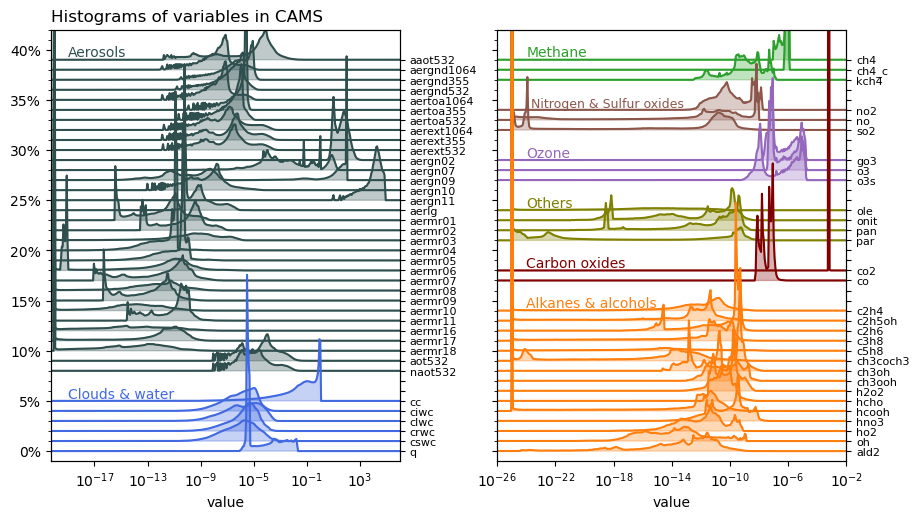

In [9]:
## plotting
fig,(ax1,ax2) = subplots(1,2,figsize=(9,5))
ax1.set_xscale("log")
ax2.set_xscale("log")

ax1y2 = ax1.twinx()
ax2y2 = ax2.twinx()

groups1colors = ["darkslategray","royalblue"]
groups2colors = ["C2","C5","C4","olive","maroon","C1"]

ioffset = 39

for (ig,group) in enumerate(groups1)

    color = groups1colors[ig]

    for i in group
        global yoffset = 0.01*ioffset

        x = (Sn[i].edges[1][4:end-3] + Sn[i].edges[1][5:end-2])/2
        y = yoffset .+ Sn[i].weights[4:end-2]

        # extend line to zero
        xprevmax = Sn[i].edges[1][end-3]       # on smaller than max
        xmax = Sn[i].edges[1][end-2]
        xmax1 = (3*xmax-xprevmax)/2            # just larger than max
        xprevinf = Sn[i].edges[1][end-1]       # floatmax
        x = vcat(0,Sn[i].edges[1][4],x,xmax,xmax1,xprevinf)
        y = vcat(yoffset,yoffset,y,Sn[i].weights[end-1]+yoffset,yoffset,yoffset)

        l = length(y)

        ax1.plot(x,y,color)
        ax1.fill_between(x,y,fill(yoffset,l),color=color,alpha=0.3)
        global ioffset -= 1
    end
    global ioffset -= 2
end

ioffset = 39

for (ig,group) in enumerate(groups2)

    color = groups2colors[ig]

    for i in group
        global yoffset = 0.01*ioffset

        x = (Sn[i].edges[1][4:end-3] + Sn[i].edges[1][5:end-2])/2
        y = yoffset .+ Sn[i].weights[4:end-2]

        # extend line to zero
        xprevmax = Sn[i].edges[1][end-3]       # on smaller than max
        xmax = Sn[i].edges[1][end-2]
        xmax1 = (3*xmax-xprevmax)/2            # just larger than max
        xprevinf = Sn[i].edges[1][end-1]       # floatmax
        x = vcat(0,Sn[i].edges[1][4],x,xmax,xmax1,xprevinf)
        y = vcat(yoffset,yoffset,y,Sn[i].weights[end-1]+yoffset,yoffset,yoffset)

        l = length(y)

        ax2.plot(x,y,color)
        ax2.fill_between(x,y,fill(yoffset,l),color=color,alpha=0.3)
        global ioffset -= 1
    end
    global ioffset -= 2
end

ax1.set_xlim(5e-21,1e6)
ax1.set_ylim(-0.01,0.42)
ax1y2.set_ylim(-0.01,0.42)

ax2.set_xlim(1e-26,1e-2)
ax2.set_ylim(-0.01,0.42)
ax2y2.set_ylim(-0.01,0.42)

dy = 0.01
ytik = Array(0:0.05:0.42)
ytikm = Array(0:dy:0.42)

ax1.set_yticks(ytik)
ax1.set_yticklabels([@sprintf("%i%%",y*100) for y in ytik])
ax1.set_yticks(ytikm,minor=true)

ax2.set_yticks(ytik)
ax2.set_yticklabels([])
ax2.set_yticks(ytikm,minor=true)

ax1y2.set_yticks(dy*collect(0:length(ax1names)-1))
ax1y2.set_yticklabels(ax1names,fontsize=8)
ax2y2.set_yticks(dy*collect(0:length(ax2names)-1))
ax2y2.set_yticklabels(ax2names,fontsize=8)

ax1.set_xlabel("value")
ax2.set_xlabel("value")
# ax1.set_ylabel("frequency")

ax1.set_title("Histograms of variables in CAMS",loc="left")
# ax2y2.set_ylabel("variable")

ax1.text(1e-19,0.393,"Aerosols",color=groups1colors[1])
ax1.text(1e-19,0.053,"Clouds & water",color=groups1colors[2])

ax2.text(1e-24,0.393,"Methane",color=groups2colors[1])
ax2.text(2e-24,0.343,"Nitrogen & Sulfur oxides",color=groups2colors[2],fontsize=9)
ax2.text(1e-24,0.293,"Ozone",color=groups2colors[3])
ax2.text(1e-24,0.243,"Others",color=groups2colors[4])
ax2.text(1e-24,0.183,"Carbon oxides",color=groups2colors[5])
ax2.text(1e-24,0.143,"Alkanes & alcohols",color=groups2colors[6])

tight_layout(rect=[0,0,1,1],pad=0.01)
savefig("histograms.png",dpi=200)